In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import copy
import pickle
from tqdm.auto import trange

import numpy as np
import numpy.random as npr
from scipy.stats import multivariate_normal as mvn
from scipy.special import logsumexp
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as manimation
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Rectangle
from matplotlib.cm import jet
from matplotlib.gridspec import GridSpec

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from ssm import HMM
from ssm.util import rle
from ssm.primitives import hmm_sample, lds_sample
from ssm.observations import GaussianObservations
from ssm.init_state_distns import InitialStateDistribution
from ssm.preprocessing import trend_filter, pca_with_imputation

In [3]:
sys.path.insert(0, '..')
import ssm_harness as harness
from ssm_harness import cached

In [4]:
npr.seed(0)
sns.set_style("white")
sns.set_context("talk")

# Load the data

In [5]:
with open("ae_latents.pkl", "rb") as f:
    data = pickle.load(f)
    
latents = data['latents'].astype(np.float64)
T_total, D = latents.shape

# Extract the segments of training data
def extract_segments(latents, indices):
    values, durations = rle(indices)
    offsets = np.concatenate(([0], np.cumsum(durations)[:-1]))
    segments = [latents[offset:offset+duration] 
                for value, offset, duration in zip(values, offsets, durations)
                if value == True]
    new_indices = [np.arange(offset,offset+duration)
                for value, offset, duration in zip(values, offsets, durations)
                if value == True]
    return segments, new_indices

training_data, train_indices = extract_segments(latents, data['indxs']['train'])
validation_data, validation_indices = extract_segments(latents, data['indxs']['validation'])
test_data, test_indices = extract_segments(latents, data['indxs']['test'])
all_training_data = np.concatenate(training_data, axis=0)

T_train = sum([len(x) for x in training_data])
T_val = sum([len(x) for x in validation_data])
T_test = sum([len(x) for x in test_data])

In [6]:
# Load the neural data
neural_data = np.load("np_spikes.npy").astype(float)
num_neurons = neural_data.shape[1]

In [7]:
# Load the VAE
import tensorflow as tf
from nntools.models import Model

vae_file = 'model_file.pkl'
vae = Model.load_model(vae_file)
vae._check_graph(None, None)

# Load the VAE weights
sess = tf.Session(graph=vae.graph, config=vae.sess_config)
checkpoint_file = 'epoch_00999.ckpt'
vae.restore_model(sess, checkpoint_file=checkpoint_file)



/Users/scott/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


model loaded from model_file.pkl
trainer: adam
data pipeline: feed_dict
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from epoch_00999.ckpt


In [8]:
def decode(trajectory):
    """
    Decode a trajectory of continuous latent states
    """
    # restore model weights from checkpoint file
    # vae.restore_model(sess, checkpoint_file=checkpoint_file)

    # populate feed_dict with latent data
    feed_dict = {vae.network.input_phs[0]: trajectory}

    # populate feed_dict with dropout rates of 1.0 (no dropout)
    for key, value in vae.network.feed_dict.items():
        feed_dict[key] = value

    # push images through network to get reconstructions
    simulated_recon = sess.run(vae.network.layer_outputs[-1], feed_dict=feed_dict)
        
    return simulated_recon


# Preprocess the neural data with smoothing and PCA

In [9]:
# _preprocess_neural_data = cached(".", "preprocessed_neural_data")(harness.preprocess_neural_data)
_preprocess_neural_data = harness.preprocess_neural_data
normalized_rates, lowd_neural_data, pca = _preprocess_neural_data(neural_data, num_components=25, fs=25, window=0.1)

Text(0.5, 0, 'PC')

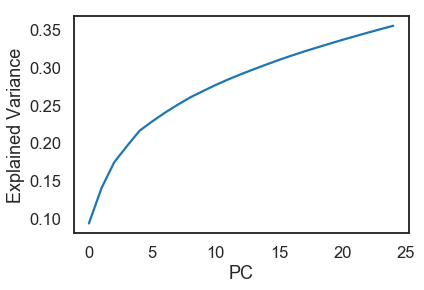

In [10]:
# Do some dimensionality reduction on the neural data
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel("Explained Variance")
plt.xlabel("PC")

In [11]:
# Choose the number of PCs to use
M = 25
training_inputs, _ = extract_segments(lowd_neural_data[:, :M], data['indxs']['train'])
validation_inputs, _ = extract_segments(lowd_neural_data[:, :M], data['indxs']['validation'])
test_inputs, _ = extract_segments(lowd_neural_data[:, :M], data['indxs']['test'])

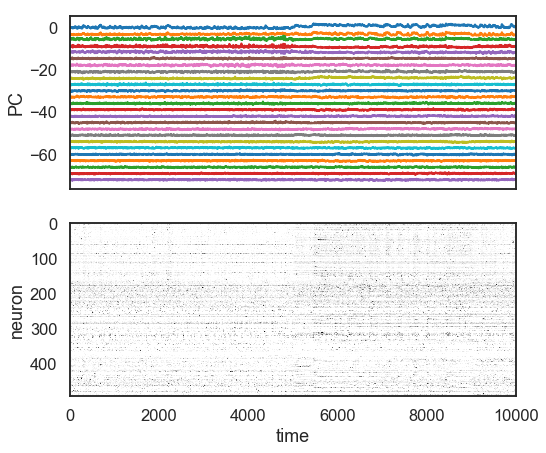

In [12]:
fig = harness.plot_neural_activity(lowd_neural_data, normalized_rates)
fig.savefig("neural_data.png", dpi=300)

# Train a linear decoder to predict VAE latents directly

In [33]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
all_xtrain = np.concatenate(training_data, axis=0)
all_utrain = np.concatenate(training_inputs, axis=0)
lr.fit(np.concatenate(training_inputs, axis=0), np.concatenate(training_data, axis=0))

x_preds_train = lr.predict(all_utrain)
x_covs = np.cov((lr_xtrain - all_xtrain).T)
x_preds_test = [lr.predict(test_input) for test_input in test_inputs]

No handles with labels found to put in legend.


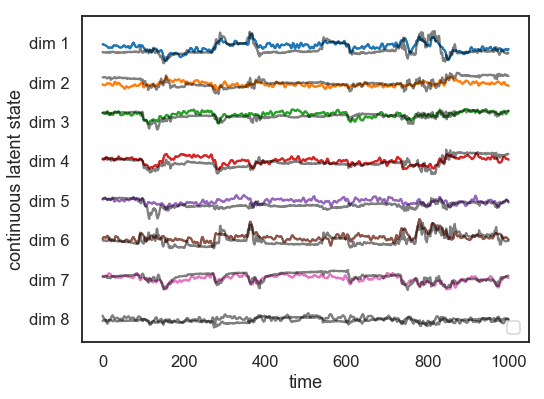

In [34]:
test_idx = 2
fig = harness.plot_sampled_latents(test_data[test_idx], [x_preds_test[test_idx]], lw=2)
fig.savefig("./lr_xpreds.png", dpi=300)

# Fit ARHMM's to the behavioral data

In [15]:
# Fit a sticky tARHMM

num_discrete_states = np.arange(8, 9)

std_models = dict(
    
    arhmm=dict(transitions="standard", 
               observations="ar"),
    
)

all_results = dict()

for model_name, kwargs in std_models.items():
    model_results = dict()
    for K in num_discrete_states:
        print("Fitting", model_name, "with", K, "states.")
        file_name = "{}_K{}.pkl".format(model_name, K)
        # _fit = cached(".", file_name)(harness.fit_model)
        _fit = harness.fit_model
        model_results[K] = _fit(K, D, 0, kwargs, 
                                training_data, validation_data, test_data)
        
    all_results[model_name] = model_results
    

Fitting arhmm with 8 states.


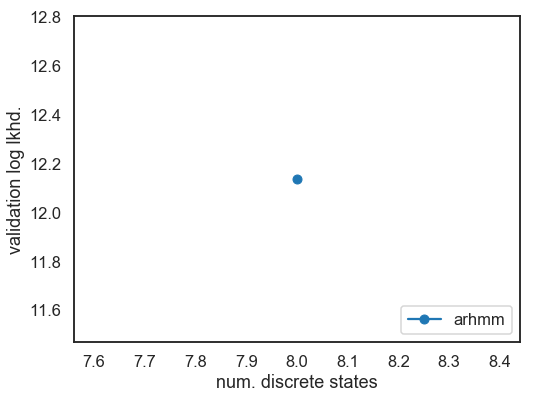

In [84]:
line_styles = dict(
    arhmm='-',
    input_arhmm='-',
    input_arhmm_zonly='-',
)

fig = harness.plot_validation_likelihoods(all_results, line_styles=line_styles, T_val=T_val)
fig.savefig("validation_likelihoods.png", dpi=300)

In [17]:
# Select the number of discrete states with the cross validated log likelihood
best_results = dict()
for model_name, model_results in all_results.items():
    val_lls = np.array([model_results[K]['val_ll'] for K in num_discrete_states])
    best_num_states = num_discrete_states[np.argmax(val_lls)]
    best_results[model_name] = model_results[best_num_states]
    
arhmm = best_results["arhmm"]["model"]

# Train a neural net to predict ARHMM states from neural data

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
z_decoder = LogisticRegression(multi_class="multinomial", solver="lbfgs")
all_ztrain = np.concatenate(best_results["arhmm"]["train_states"], axis=0)
all_utrain = np.concatenate(training_inputs, axis=0)
z_decoder.fit(all_utrain, all_ztrain)

/Users/scott/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
z_logprobs_train = z_decoder.predict_log_proba(all_utrain)
z_logprobs_test = [z_decoder.predict_log_proba(test_input) for test_input in test_inputs]

Text(0.5, 1.0, 'Neural Decoder Behavioral State Prob.')

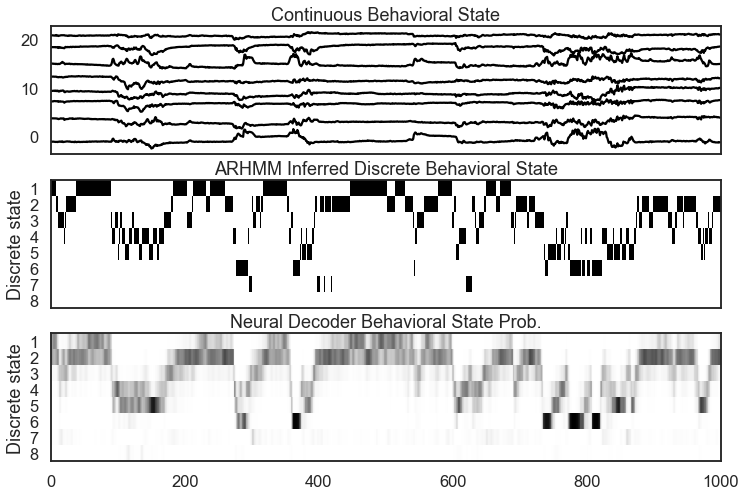

In [30]:
test_idx = 2
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(test_data[test_idx] + 3 * np.arange(D), '-k')
plt.xlim(0, 1000)
plt.xticks([])
plt.title("Continuous Behavioral State")

plt.subplot(312)
onehot = lambda z: np.arange(arhmm.K) == z[:, None]
plt.imshow(onehot(arhmm.most_likely_states(test_data[test_idx])).T,
           aspect="auto", cmap="Greys", vmin=0, vmax=1)
plt.yticks(np.arange(arhmm.K), np.arange(arhmm.K)+1)
plt.ylabel("Discrete state")
plt.xlim(0, 1000)
plt.xticks([])
plt.title("ARHMM Inferred Discrete Behavioral State")

plt.subplot(313)
plt.imshow(np.exp(z_logprobs_test[test_idx].T), 
           aspect="auto", cmap="Greys", vmin=0, vmax=1)
plt.yticks(np.arange(arhmm.K), np.arange(arhmm.K)+1)
plt.ylabel("Discrete state")
plt.xlim(0, 1000)
plt.title("Neural Decoder Behavioral State Prob.")

# fig = harness.plot_sampled_latents(test_data[test_idx], [lr_xtest[test_idx]], lw=2)
# fig.savefig("./lr_xpreds.png", dpi=300)

# Combine the neural predictions with the ARHMM prior to decode behavioral states

In [69]:
from pyslds.models import HMMSLDS
from pyslds.states import HMMSLDSStatesEigen

from pybasicbayes.distributions import Gaussian, Regression

class NeuralNetDecoderSLDSStates(HMMSLDSStatesEigen):
    """
    Override the SLDS potentials with those from a neural net.
    
    """
    def __init__(self, model, x_preds=None, x_covs=None, z_logprobs=None, 
                 x_scale=1.0, z_scale=1.0, **kwargs):
        """
        :param x_preds:     TxD array of decoded continuous states from neural net.
        :param x_covs:      DxD or TxDxD array of decoded covariance of continuous states from neural net.
        :param z_logprobs:  TxK array of log probabilities of discrete states from neural net.
        :param x_scale:     positive scalar value indicating how much to weight the continuous predictions. 
        :param z_scale:     positive scalar value indicating how much to weight the discrete predictions. 
        
        Other kwargs include data, 
        """
        super(NeuralNetDecoderSLDSStates, self).__init__(model, **kwargs)
        
        # Precompute the info form potentials from the decoder
        assert np.isscalar(x_scale)
        T, D = x_preds.shape
        assert T == self.T
        assert D == self.D_latent
        assert x_covs.shape == (T, D, D) or x_covs.shape == (D, D)
        self.J_node = x_scale * np.linalg.inv(x_covs) * np.ones((self.T, self.D_latent, self.D_latent))
        self.h_node = x_scale * np.matmul(self.J_node, x_preds[:, :, None])[:, :, 0]
        self.log_Z_node = np.zeros(self.T)
        
        # Precompute the discrete state potentials from the decoder
        assert np.isscalar(z_scale)
        T, K = z_logprobs.shape
        assert T == self.T
        assert K == self.num_states
        self.decoder_aBl = z_scale * z_logprobs
        
    # Override the emissions parameters with the J and h given by the decoder
    # J = Sigma^{-1} and h = Sigma^{-1} mu.  These are the natural parameters
    # of the multivariate normal distribution
    @property
    def info_emission_params(self):
        return self.J_node, self.h_node, self.log_Z_node
    
    # Override the discrete potentials too
    @property
    def aBl(self):
        if self._aBl is None:
            self._aBl = np.zeros((self.T, self.num_states))
            ids, dds = self.init_dynamics_distns, self.dynamics_distns

            for idx, (d1, d2) in enumerate(zip(ids, dds)):
                # Initial state distribution
                self._aBl[0, idx] = d1.log_likelihood(self.gaussian_states[0])

                # Dynamics
                xs = np.hstack((self.gaussian_states[:-1], self.inputs[:-1]))
                self._aBl[:-1, idx] = d2.log_likelihood((xs, self.gaussian_states[1:]))

            # Add the decoder potential
            self._aBl += self.decoder_aBl
            
            # Handle NaN's
            self._aBl[np.isnan(self._aBl).any(1)] = 0.

        return self._aBl
    

class NeuralNetDecoderSLDS(HMMSLDS):
    _states_class = NeuralNetDecoderSLDSStates
    
    def __init__(self, arhmm):
        """
        Build the decoder from an SSM autoregressive hidden Marko model
        """
        K = arhmm.K          # number of discrete states
        D_latent = arhmm.D   # dimensionality of continuous latents
        D_input = 1          # input dimensionality is 1 for the affine term
        D_obs = 1            # dummy value

        # Initialize the initial state distribution of the continuous states
        init_dynamics_distns = \
            [Gaussian(nu_0=D_latent+3,
                      sigma_0=3.*np.eye(D_latent),
                      mu_0=np.zeros(D_latent),
                      kappa_0=0.01)
             for _ in range(K)]

        for id, mu, sigma in zip(init_dynamics_distns, 
                                 arhmm.observations.mu_init,
                                 arhmm.observations.Sigmas_init):
            id.mu = mu
            id.sigma = sigma
        
        # Initialize dynamics distributions
        dynamics_distns = [Regression(
            nu_0=D_latent + 1,
            S_0=D_latent * np.eye(D_latent),
            M_0=np.hstack((.99 * np.eye(D_latent), np.zeros((D_latent, D_input)))),
            K_0=D_latent * np.eye(D_latent + D_input))
            for _ in range(K)]
        
        # Combine (A, b) into a single matrix
        Abs = [np.column_stack((A, b)) for A, b in zip(arhmm.observations.As, arhmm.observations.bs)]
        for dd, Ab, sigma in zip(dynamics_distns, Abs, arhmm.observations.Sigmas):
            dd.A = Ab
            dd.sigma = sigma
            
        # Initialize the transitions
        trans_matrix = np.exp(arhmm.transitions.log_Ps)
        assert np.allclose(trans_matrix.sum(1), 1)

        # Initialize the initial state distribution
        pi_0 = np.exp(arhmm.init_state_distn.log_pi0)
        
        # Call the super constructor with these distributions
        super(NeuralNetDecoderSLDS, self).__init__(
            init_dynamics_distns=init_dynamics_distns,
            dynamics_distns=dynamics_distns,
            emission_distns=None,
            pi_0=pi_0, init_state_concentration=1,
            trans_matrix=trans_matrix, alpha=1)

        
    def add_data(self, x_preds, x_covs, z_logprobs, x_scale=1, z_scale=1):
        # Make dummy data for these predictions
        T = x_preds.shape[0]
        dummy_data = np.zeros((T, 1))
        dummy_inputs = np.ones((T, 1))
        
        # Construct a states object for these predictions
        self.states_list.append(
            NeuralNetDecoderSLDSStates(
                model=self, data=dummy_data, inputs=dummy_inputs,
                x_preds=x_preds, x_covs=x_covs, z_logprobs=z_logprobs,
                x_scale=x_scale, z_scale=z_scale,
                stateseq=None, fixed_stateseq=False))
        
        return self.states_list[-1]
    

In [70]:
# Fit with another LDS.  Give it twice as many states in
# order to have some flexibility during inference.
slds = NeuralNetDecoderSLDS(arhmm)

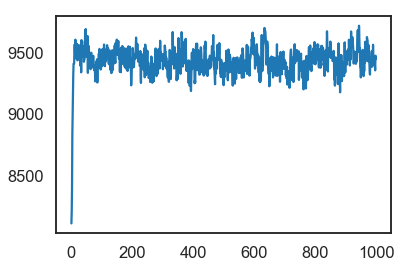

In [71]:
test_idx = 2
T_smpl = test_inputs[test_idx].shape[0]
slds.add_data(x_preds_test[test_idx], x_covs, z_logprobs_test[test_idx])
states = slds.states_list.pop()

z_smpls = []
x_smpls = []
ll_smpls = []
for itr in trange(1000):
    states.resample()
    z_smpls.append(states.stateseq.copy())
    x_smpls.append(states.gaussian_states.copy())
    ll_smpls.append(states.log_likelihood())

plt.plot(ll_smpls[1:])

No handles with labels found to put in legend.


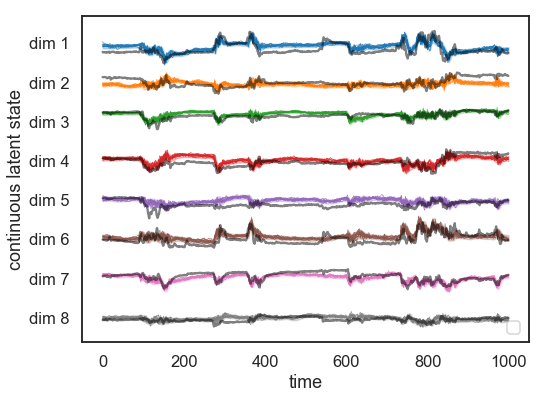

In [72]:
fig = harness.plot_sampled_latents(test_data[test_idx], x_smpls[-500:])
fig.savefig("./bayesian_decoder.png", dpi=300)

No handles with labels found to put in legend.


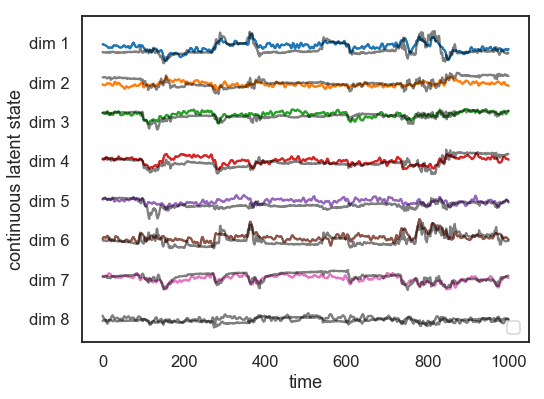

In [73]:
fig = harness.plot_sampled_latents(test_data[test_idx], [lr.predict(test_inputs[test_idx])], lw=2)
fig.savefig("./linear_decoder.png", dpi=300)

const:   0.517
linreg:  0.277
bayes:   0.251


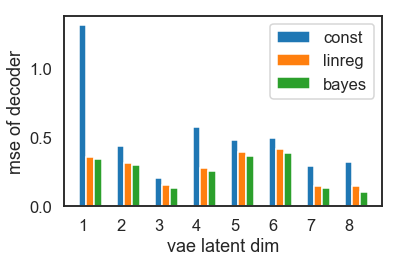

In [74]:
# Compare MSE of Bayesian mean vs linear decoder
mse_const = np.mean((test_data[test_idx] - np.concatenate(training_data).mean(0))**2, axis=0)
mse_lr = np.mean((test_data[test_idx] - lr.predict(test_inputs[test_idx]))**2, axis=0)
mse_bayes = np.mean((test_data[test_idx] - np.mean(x_smpls[-500:], axis=0))**2, axis=0)

plt.bar(np.arange(D), mse_const, width=.2, label="const")
plt.bar(np.arange(D)+.2, mse_lr, width=.2, label="linreg")
plt.bar(np.arange(D)+.4, mse_bayes, width=.2, label="bayes")
plt.xticks(np.arange(D), np.arange(D) + 1)
plt.xlabel("vae latent dim")
plt.ylabel("mse of decoder")
plt.legend(loc="upper right")

plt.tight_layout()

print("const:  ", np.mean(mse_const).round(3))
print("linreg: ", np.mean(mse_lr).round(3))
print("bayes:  ", np.mean(mse_bayes).round(3))

plt.savefig("./mse_decoder.png", dpi=300)

In [ ]:
print("Decoding the real VAE latents to images")
decoded_latents = decode(test_data[test_idx])
arhmm_states = arhmm.most_likely_states(test_data[test_idx])

In [79]:
print("Decoding Bayesian decoder states to images")
decoded_bayes = decode(np.mean(x_smpls[-500:], axis=0))
decoded_bayes_states = z_smpls[-1]

Decoding Bayesian decoder states to images


In [80]:
print("Decoding linear regression predictions")
decoded_lr = decode(x_preds_test[test_idx])
decoded_lr_states = np.argmax(z_logprobs_test[test_idx], axis=1)

Decoding linear regression predictions


In [ ]:
harness.make_hollywood_movie(slds.num_states,
                             decoded_latents, 
                             arhmm_states,
                             [decoded_bayes, decoded_lr],
                             [decoded_bayes_states, decoded_lr_states],
                             titles=["Real", "Bayes", "LinReg"])